In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('/home/kruu/git_folder/eye_tracking/')

from utils.data_processing import EyeTrackingProcessor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

****
# Data Processing
****

In [2]:
path_001 = 'data/Project1 Data export raw_001.tsv'
path_002 = 'data/Project1 Data export raw_002.tsv'
path_003 = 'data/Project1 Data export raw_003.tsv'
path_004 = 'data/Project1 Data export raw_004.tsv'
path_005 = 'data/Project1 Data export raw_005.tsv'
path_006 = 'data/Project1 Data export raw_006.tsv'
path_007 = 'data/Project1 Data export raw_007.tsv'
path_008 = 'data/Project1 Data export raw_008.tsv'
path_list = [path_001, path_002, path_003, path_004, path_005, path_006, path_007, path_008]

tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
features = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Participant name']
interpolate_col = ['Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y']

processor = EyeTrackingProcessor()
all_data = processor.load_data(path_list)
dataset = processor.get_features(all_data, tasks, features)

#Fixed Time step resampling
dataset_resampled = processor.fixed_time_steps_resample(dataset, interpolate_col, timestep = 1/120, pad_value = np.nan)

#Chunk per task
dataset_chunked = processor.get_chunks(dataset, chunk_duration=5*1e6, time_offset_chunk=0.5*1e6)
dataset_chunked_resampled = processor.fixed_length_resample(dataset_chunked, interpolate_col, target_size=600)

/home/kruu/git_folder/eye_tracking/utils/data_processing.py:19: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')


Only Nans for participant 7, task 3, execution 3, chunk 0
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 3, execution 3, chunk 1
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 3, execution 3, chunk 2
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 3, execution 3, chunk 3
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 3, execution 3, chunk 4
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 3, execution 3, chunk 5
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 3, execution 3, chunk 6
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 5, execution 5, chunk 0
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 5, execution 5, chunk 1
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 5, execution 5, chunk 2
['Gaze point X', 'Gaze point Y']

Only Nans for participant 7, task 5, execution 5, chunk 3
['Gaze point X', 'Gaze

****
# Full task visualisation
****

In [9]:
dataset_resampled

,Recording timestamp,Gaze point X,Gaze point Y,Mouse position X,Mouse position Y,Participant name,Task_id,Task_execution
0,2.083195e+08,1670.000000,884.000000,-918.0,312.0,1,1,0
1,2.083279e+08,1656.005358,890.997321,-918.0,312.0,1,1,0
2,2.083362e+08,1637.143011,893.977419,-888.0,321.0,1,1,0
3,2.083445e+08,1656.995200,877.004080,-888.0,321.0,1,1,0
4,2.083529e+08,1662.998080,876.000320,-888.0,321.0,1,1,0
...,...,...,...,...,...,...,...,...
2042491,NaN,NaN,NaN,NaN,NaN,8,6,5
2042492,NaN,NaN,NaN,NaN,NaN,8,6,5
2042493,NaN,NaN,NaN,NaN,NaN,8,6,5
2042494,NaN,NaN,NaN,NaN,NaN,8,6,5


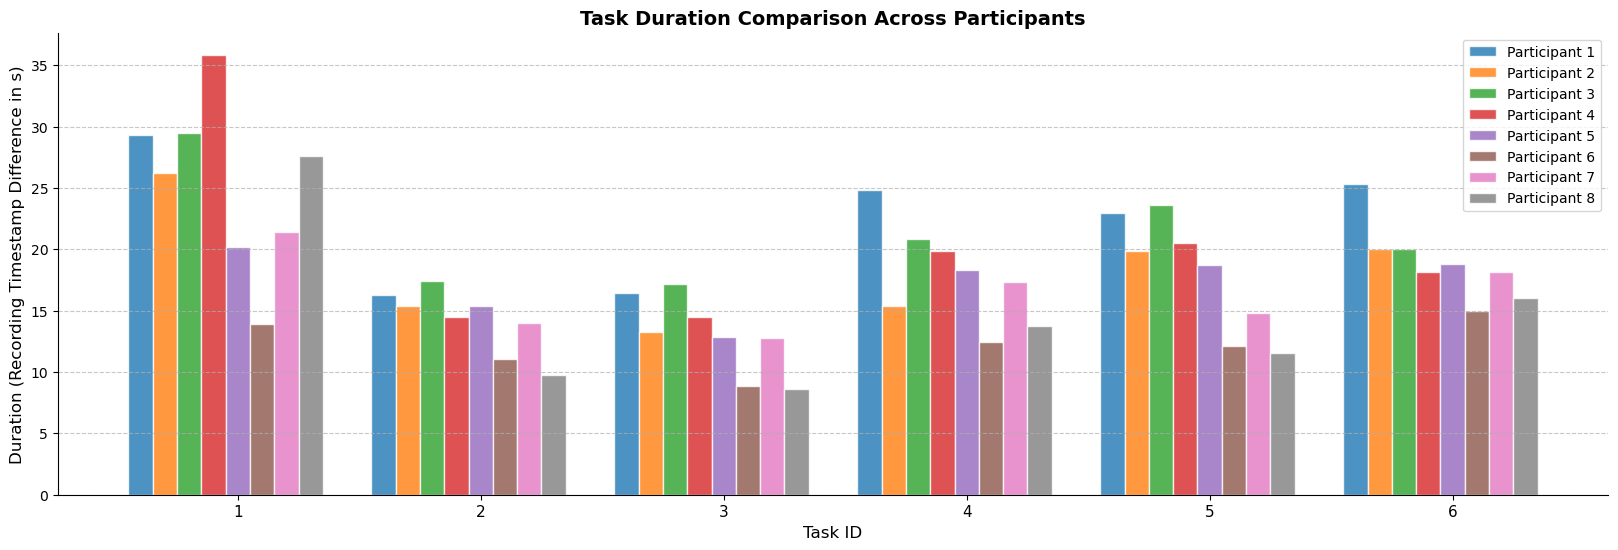

In [10]:
import matplotlib.colors as mcolors

durations = pd.DataFrame(dataset_resampled.groupby(['Participant name', 'Task_id', 'Task_execution'])['Recording timestamp'].agg(lambda x: (x.max() - x.min())/1e6).reset_index().groupby(['Participant name', 'Task_id'])['Recording timestamp'].mean()).reset_index()

plt.figure(figsize=(20, 6))
pastel_colors = list(mcolors.TABLEAU_COLORS.values())
bar_width = 0.1
task_ids = sorted(durations["Task_id"].unique())
participants = sorted(durations["Participant name"].unique())
x_indexes = np.arange(len(task_ids))

# Plot bars for each participant
for i, participant in enumerate(participants):
    participant_data = durations[durations["Participant name"] == participant]
    plt.bar(x_indexes + i * bar_width, participant_data["Recording timestamp"], 
            width=bar_width, color=pastel_colors[i % len(pastel_colors)], 
            edgecolor='white', alpha=0.8, label=f'Participant {participant}')

# Formatting
plt.xlabel("Task ID", fontsize=12)
plt.ylabel("Duration (Recording Timestamp Difference in s)", fontsize=12)
plt.title("Task Duration Comparison Across Participants", fontsize=14, fontweight='bold')

plt.xticks(x_indexes + (bar_width * (len(participants) / 2)), task_ids, fontsize=11) 

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(fontsize=10)

plt.show()


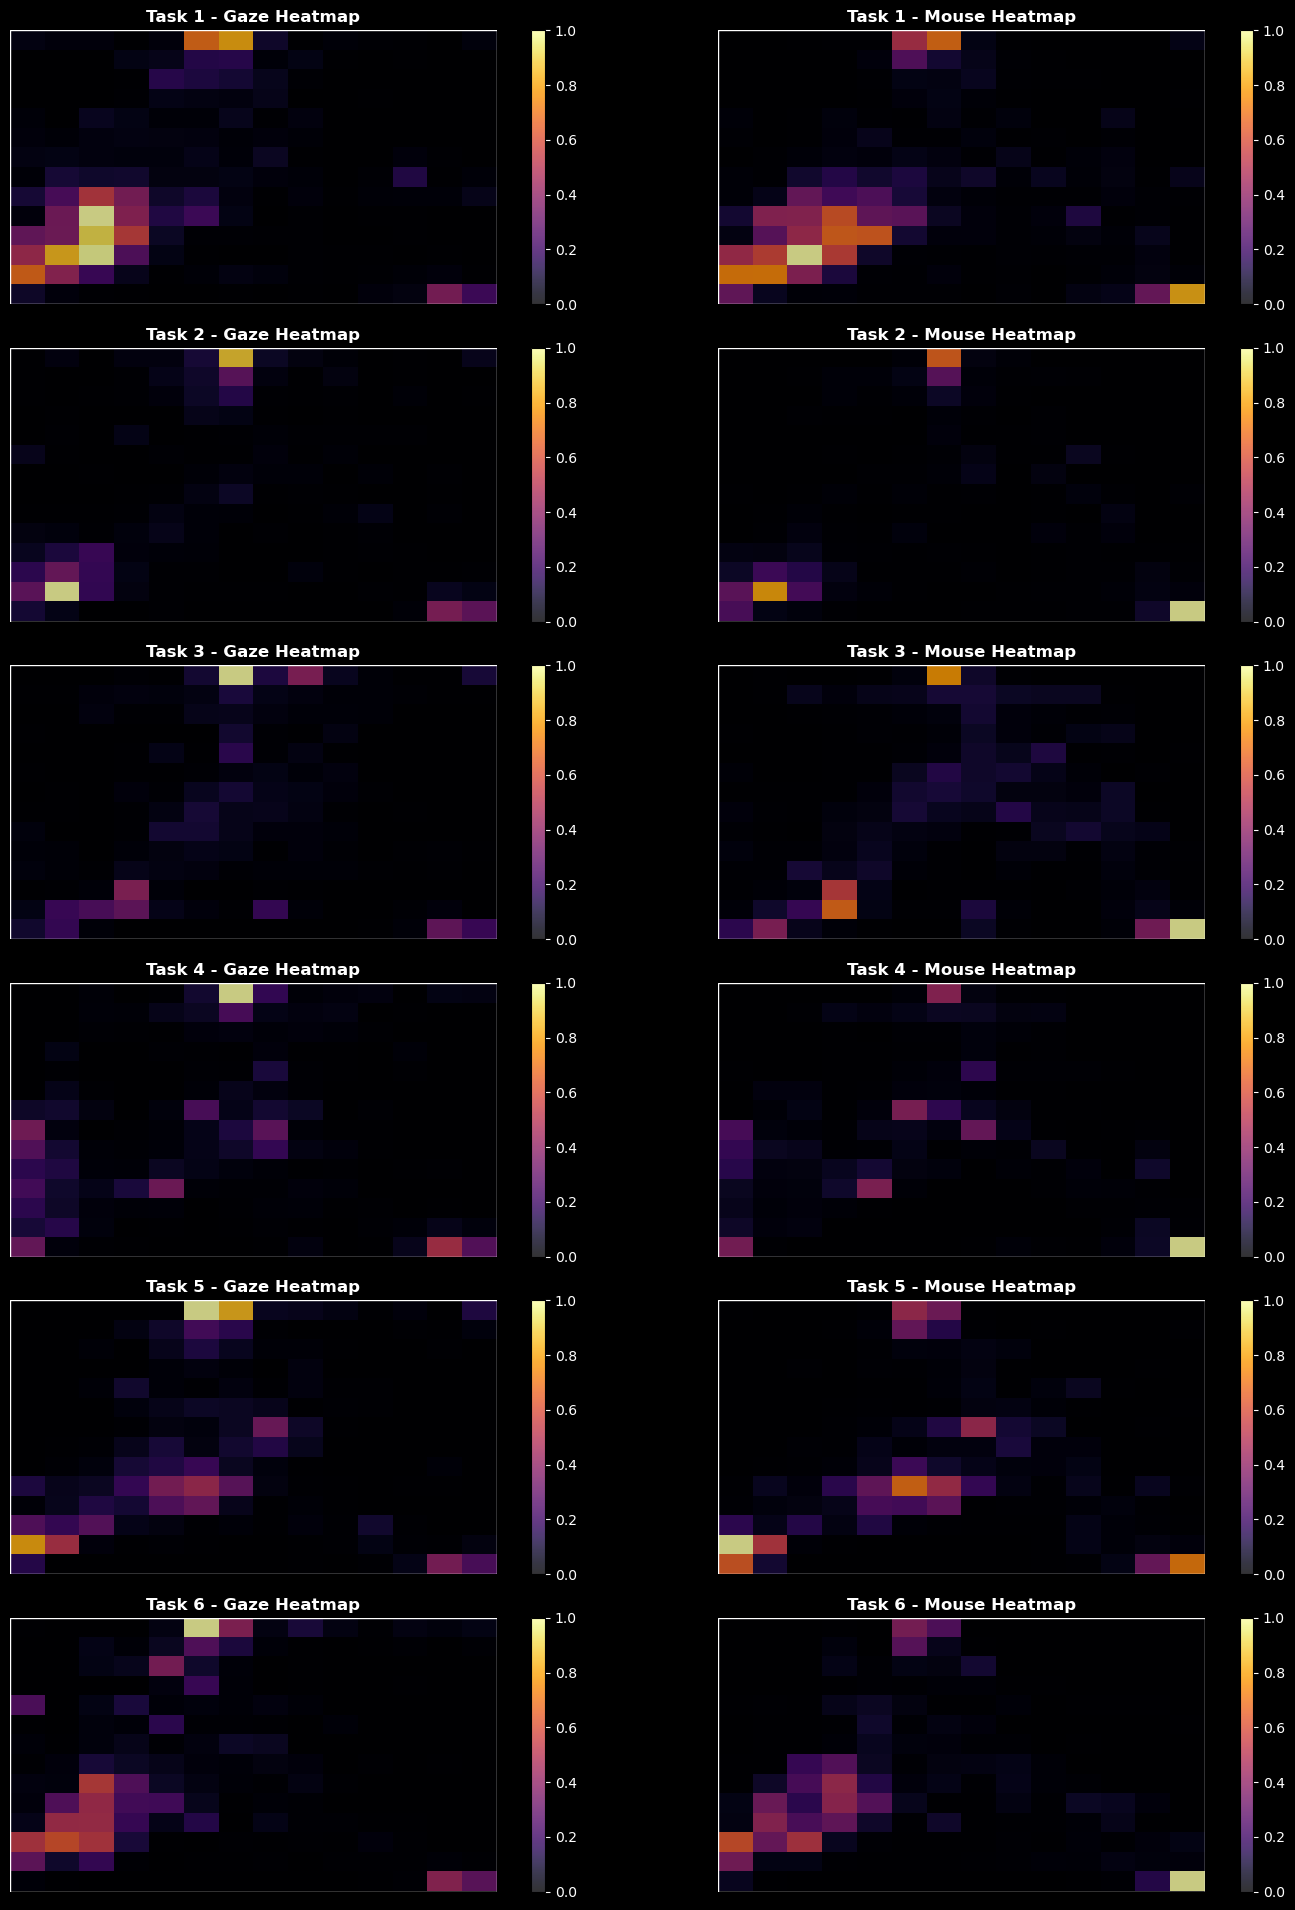

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

screen_width = 1920
screen_height = 1080
bins = 15
fig, axes = plt.subplots(6, 2, figsize=(18, 20))  # Increased height for better spacing

for i in range(0, 6): 
    plot_df = dataset_resampled.query(f"Task_id == {i+1}")
    gaze_x, gaze_y = plot_df["Gaze point X"], plot_df["Gaze point Y"]
    mouse_x, mouse_y = plot_df["Mouse position X"], plot_df["Mouse position Y"]

    bins_x = np.linspace(0, screen_width, bins)
    bins_y = np.linspace(0, screen_height, bins)
    heatmap_gaze, _, _ = np.histogram2d(gaze_x, gaze_y, bins=[bins_x, bins_y])
    heatmap_mouse, _, _ = np.histogram2d(mouse_x, mouse_y, bins=[bins_x, bins_y])

    # Normalize heatmaps for better visualization
    if np.max(heatmap_gaze) > 0:
        heatmap_gaze = heatmap_gaze / np.max(heatmap_gaze)
    if np.max(heatmap_mouse) > 0:
        heatmap_mouse = heatmap_mouse / np.max(heatmap_mouse)


    ax1, ax2 = axes[i, 0], axes[i, 1]
    
    # Gaze Heatmap
    im1 = ax1.imshow(heatmap_gaze.T, extent=[0, screen_width, 0, screen_height], 
                     origin="lower", cmap="inferno", alpha=0.8)
    ax1.add_patch(plt.Rectangle((0, 0), screen_width, screen_height, fill=None, color='white', linewidth=1))
    ax1.set_title(f"Task {i+1} - Gaze Heatmap", fontsize=12, fontweight="bold", color="white")
    ax1.set_xlim(0, screen_width)
    ax1.set_ylim(0, screen_height)
    ax1.axis("off")

    cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.ax.tick_params(labelsize=10, colors="white")

    # Mouse Heatmap
    im2 = ax2.imshow(heatmap_mouse.T, extent=[0, screen_width, 0, screen_height], 
                     origin="lower", cmap="inferno", alpha=0.8)
    ax2.add_patch(plt.Rectangle((0, 0), screen_width, screen_height, fill=None, color='white', linewidth=1))
    ax2.set_title(f"Task {i+1} - Mouse Heatmap", fontsize=12, fontweight="bold", color="white")
    ax2.set_xlim(0, screen_width)
    ax2.set_ylim(0, screen_height)
    ax2.axis("off")

    cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    cbar2.ax.tick_params(labelsize=10, colors="white")

# Improve layout
plt.tight_layout(rect=[0, 0, 0.90, 0.96])
fig.patch.set_facecolor('black') 
plt.show()


In [ ]:
# Projection of time series in a 2D space using PCA or whatever

proj_task_dataset = dataset_resampled.copy()
# Add a  columns "sample_id" to dataset which is the index for the combination of "Participant name", "Task_id", "Task_execution"
proj_task_dataset["sample_id"] = proj_task_dataset.groupby(["Participant name", "Task_id", "Task_execution"]).ngroup()
proj_task_dataset["sample_id"] = proj_task_dataset["sample_id"].astype(str)

placeholder_value = np.nan
# Identifying outside the screen seems to decrease the performance
# proj_task_dataset_resampled = processor.outside_screen_placeholder(proj_task_dataset, [-200, 2120], [-200, 1280], placeholder_value)
proj_task_dataset_resampled = proj_task_dataset

def flatten_group(group):
    return np.concatenate([
        group['Gaze point X'].values,
        group['Gaze point Y'].values,
        group['Mouse position X'].values,
        group['Mouse position Y'].values
    ])

# Grouping by participant, task, execution
proj_task_dataset_resampled = proj_task_dataset_resampled.groupby(['Participant name', 'Task_id', 'Task_execution']).apply(flatten_group)

# Flatten column names after aggregation
proj_task_dataset_resampled = proj_task_dataset_resampled.reset_index()
proj_task_dataset_resampled.columns = ['Participant name', 'Task_id', 'Task_execution', 'flattened_features']

# Extract features (X) and labels (y)
X_proj = np.vstack(proj_task_dataset_resampled['flattened_features'].values)
y_proj = proj_task_dataset_resampled['Task_id'].values


/tmp/ipykernel_481383/510770326.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  proj_task_dataset_resampled = proj_task_dataset_resampled.groupby(['Participant name', 'Task_id', 'Task_execution']).apply(flatten_group)


/tmp/ipykernel_481383/49335552.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


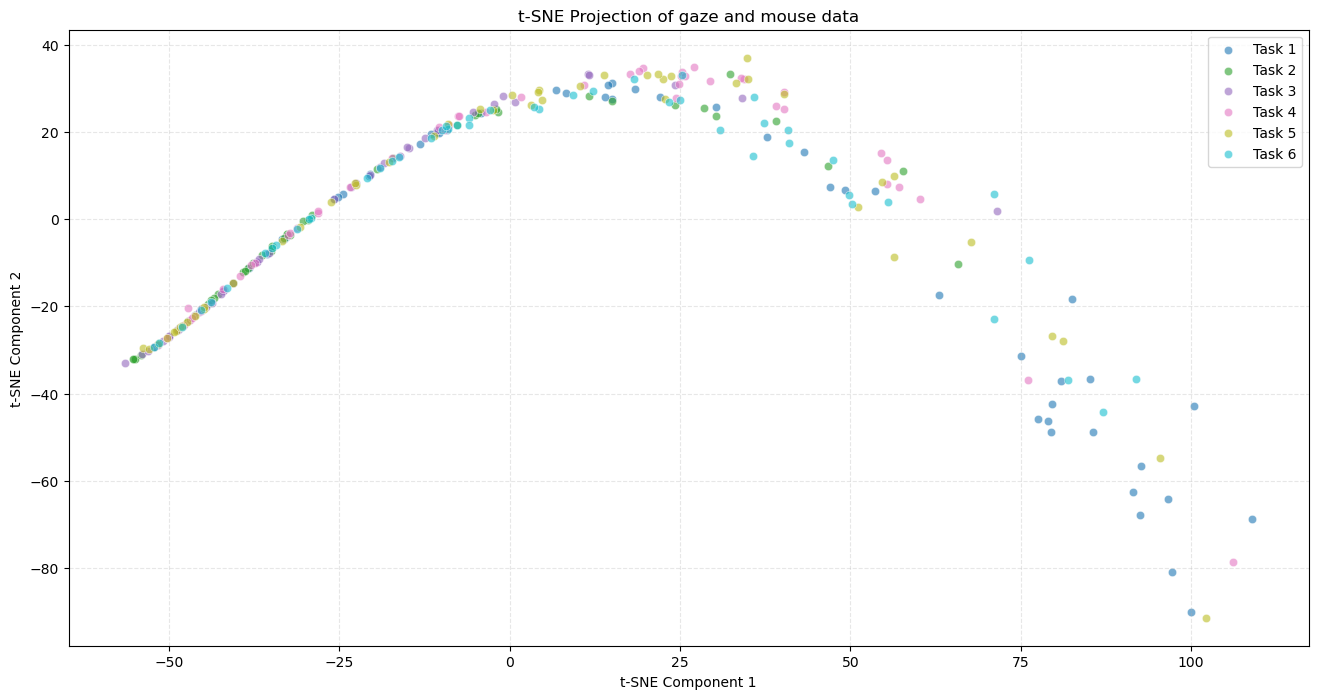

In [24]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

scaler_proj = MinMaxScaler()
X_proj_scaled = scaler_proj.fit_transform(X_proj)
X_proj_scaled = np.where(np.isnan(X_proj), -1, X_proj_scaled)

# tsne = TSNE(n_components=2, random_state=0)
# embeddings = tsne.fit_transform(X_proj_scaled)

pca = PCA(n_components=2)
embeddings = pca.fit_transform(X_proj_scaled)

# Create a color map for labels
unique_labels = np.unique(y_proj)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

# Plot the t-SNE projection with colored labels
plt.figure(figsize=(16, 8))
for i, label in enumerate(unique_labels):
    indices = y_proj == label
    plt.scatter(embeddings[indices, 0], embeddings[indices, 1],
                color=colors(i), label=f'Task {label}', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.title('t-SNE Projection of gaze and mouse data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(alpha=0.3, linestyle = "--")
plt.show()

In [25]:
pca.explained_variance_ratio_

array([0.44022803, 0.16043946])

In [26]:
scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X_proj, y_proj, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Replace nans with -1 after scaling: they are indicating outside of the screen
X_train_scaled = np.where(np.isnan(X_train_scaled), -1, X_train_scaled)
X_test_scaled = np.where(np.isnan(X_test_scaled), -1, X_test_scaled)

In [28]:
# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear']  # Kernel type
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
print(best_params)

# Train SVM
svm_model = SVC(kernel=best_params["kernel"], C=best_params["C"], gamma=best_params["gamma"])
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(classification_rep)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.25862068965517243
              precision    recall  f1-score   support

           1       0.43      0.20      0.27        15
           2       0.50      0.36      0.42        11
           3       0.22      0.67      0.33         6
           4       0.00      0.00      0.00         8
           5       0.25      0.09      0.13        11
           6       0.19      0.43      0.26         7

    accuracy                           0.26        58
   macro avg       0.26      0.29      0.24        58
weighted avg       0.30      0.26      0.24        58



Idea: perform somehow a transfer learning:
- Find an algorithm that manages efficiently to classify the time series. We can say that the feature extraction works with that.
- Use the same feature extractor on chunks of data and seen if it's possible to classify them as well. 
- The resampling with chunks of the same duration is alright. But when dealing with the full ts that have different durations, we cannot resample them at the same rate because then the temporality is not respected. Ideas to deal with that: 
    - Using a regural time parameterisation and then using padding to account for different lengths
    - Not bothering about the time and representing the gaze and mouse data as images (heatmaps), and classifying them with knn. Nice but then it's hard to do some transfer learning with temporal data with the chunks. 

****
# Chunk comparison
***

In [ ]:
# Verification of chunk durations
# Some full tasks are lower than the chunk duration
test = dataset_chunked.groupby(['Participant name', 'Task_id', 'Task_execution', 'chunk_id'])["Recording timestamp"].agg(lambda x: (x.max() - x.min())/1e6)
test.describe()

In [ ]:
dataset_chunked_resampled.isna().sum()

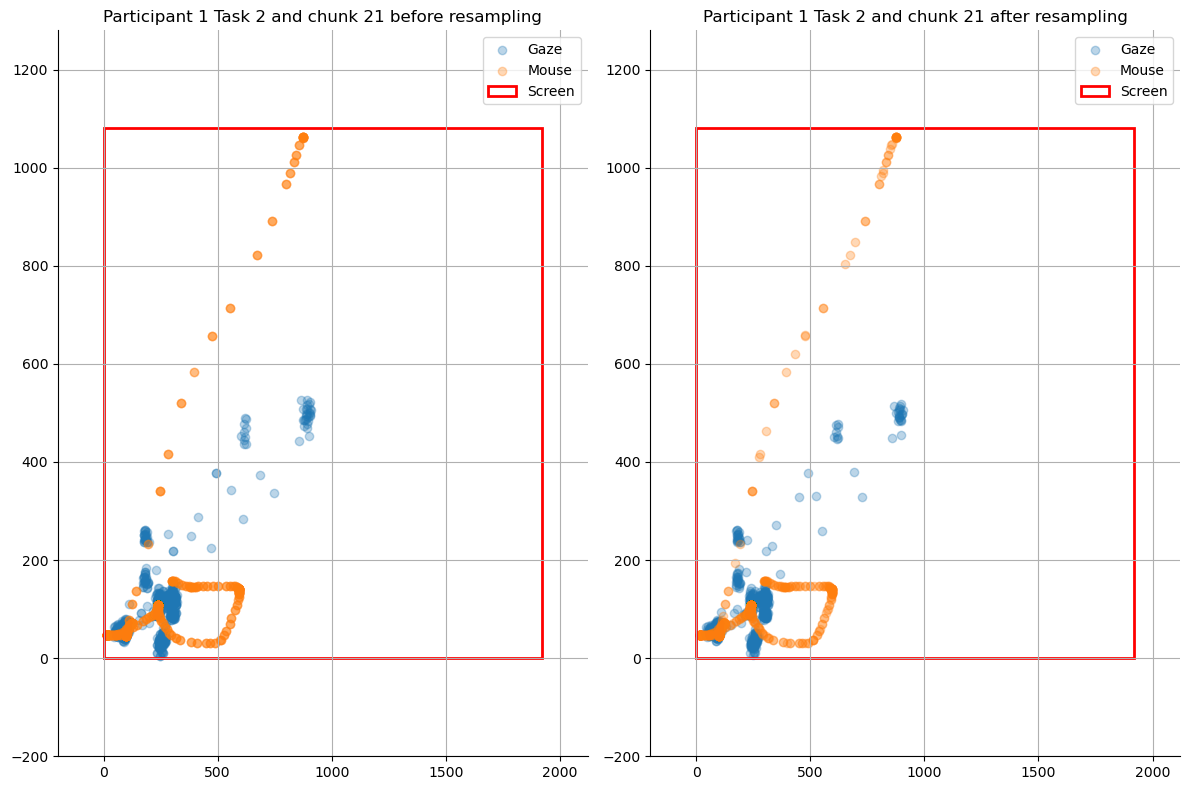

In [9]:
# Comparision of chunks before and after resampling
participant = np.random.choice(dataset_chunked["Participant name"].unique())
task_id = np.random.choice(dataset_chunked["Task_id"].unique())
task_execution = np.random.choice(dataset_chunked["Task_execution"].unique())
data_plot = dataset_chunked.query(f"`Participant name` == {participant} and Task_id == {task_id} and Task_execution == {task_execution}")
chunk_id = np.random.choice(data_plot["chunk_id"].dropna().unique())
data_plot_initial = data_plot.query(f"chunk_id == {chunk_id}")
data_plot_resampled = dataset_chunked_resampled.query(f"`Participant name` == {participant} and Task_id == {task_id} and Task_execution == {task_execution} and chunk_id == {chunk_id}")

fig, axes = plt.subplots(1, 2, figsize=(12, 8)) 
axes = axes.flatten()
axes[0].scatter(data_plot_initial["Gaze point X"], data_plot_initial["Gaze point Y"], label="Gaze", alpha=0.3)
axes[0].scatter(data_plot_initial["Mouse position X"], data_plot_initial["Mouse position Y"], label="Mouse", alpha=0.3)
axes[0].set_title(f"Participant {participant} Task {task_id} and chunk {chunk_id} before resampling")
axes[0].add_patch(plt.Rectangle((0, 0), 1920, 1080, fill=None, color='r', linewidth=2, label="Screen"))
axes[0].legend()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].grid(True)
axes[0].set_xlim(-200, 2120)
axes[0].set_ylim(-200, 1280)

axes[1].scatter(data_plot_resampled["Gaze point X"], data_plot_resampled["Gaze point Y"], label="Gaze", alpha=0.3)
axes[1].scatter(data_plot_resampled["Mouse position X"], data_plot_resampled["Mouse position Y"], label="Mouse", alpha=0.3)
axes[1].set_title(f"Participant {participant} Task {task_id} and chunk {chunk_id} after resampling")
axes[1].add_patch(plt.Rectangle((0, 0), 1920, 1080, fill=None, color='r', linewidth=2, label="Screen"))
axes[1].legend()
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].grid(True)
axes[1].set_xlim(-200, 2120)
axes[1].set_ylim(-200, 1280)


plt.tight_layout()
plt.show()

****
# Model Training
****

First idea:
- One sample is 600 observations, for one participant, one task, and one chunk_id
- Label is task_id
- First we will work on aggregated features like min/max/mean/std to see if they are sufficient to predict. If not we will use the full time series and train an LSTM of whatever. 
- Try using multi-head 2D CNN: one for gazeX/Y and another one for MouseX/Y

In [ ]:
#If the gaze or mouse is outside the screen, we replace the value with nan
placeholder_value = np.nan
train_dataset = processor.outside_screen_placeholder(dataset_chunked_resampled, [-200, 2120], [-200, 1280], placeholder_value)

# We can add a missingness Indicator Feature
# for col in features:
#     dataset[col + "_missing"] = (dataset[col] == placeholder_value).astype(int)

In [9]:
def flatten_group(group):
    return np.concatenate([
        group['Gaze point X'].values,
        group['Gaze point Y'].values,
        group['Mouse position X'].values,
        group['Mouse position Y'].values
    ])

# Grouping by participant, task, execution, and chunk
grouped_data = train_dataset.groupby(['Participant name', 'Task_id', 'Task_execution', 'chunk_id']).apply(flatten_group)

# Flatten column names after aggregation
flattened_df = grouped_data.reset_index()
flattened_df.columns = ['Participant name', 'Task_id', 'Task_execution', 'chunk_id', 'flattened_features']

# Extract features (X) and labels (y)
X = np.vstack(flattened_df['flattened_features'].values)
y = flattened_df['Task_id'].values

# Train/test split (WARNING: split before if using time series data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/tmp/ipykernel_152864/3585948980.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_data = train_dataset.groupby(['Participant name', 'Task_id', 'Task_execution', 'chunk_id']).apply(flatten_group)


In [10]:
scaler = MinMaxScaler()

# MinMaxScaler automatically keep nans out of scaling
# We can also set ourselves the values of MinMax with the screen limits
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Replace nans with -1 after scaling: they are indicating outside of the screen
X_train_scaled = np.where(np.isnan(X_train_scaled), -1, X_train_scaled)
X_test_scaled = np.where(np.isnan(X_test_scaled), -1, X_test_scaled)


In [12]:
# # Define the hyperparameter grid
# param_grid = {
#     'C': [0.1, 1, 10, 100],  # Regularization parameter
#     'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
#     'kernel': ['rbf', 'linear']  # Kernel type
# }

# # Perform Grid Search with cross-validation
# grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
# grid_search.fit(X_train_scaled, y_train)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# print(best_params)

# Train SVM
# svm_model = SVC(kernel=best_params["kernel"], C=best_params["C"], gamma=best_params["gamma"])
svm_model = SVC(kernel="rbf", C=10, gamma="auto")
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(classification_rep)

0.40885072655217963
              precision    recall  f1-score   support

           1       0.39      0.74      0.51       411
           2       0.46      0.35      0.39       197
           3       0.48      0.28      0.35       155
           4       0.47      0.41      0.44       240
           5       0.34      0.26      0.29       229
           6       0.41      0.16      0.23       282

    accuracy                           0.41      1514
   macro avg       0.42      0.37      0.37      1514
weighted avg       0.42      0.41      0.38      1514



Ideas to implement:
- Maybe explore an algorithm that is based on the full task and try to recognise if what he is observing is a bit of the full task. 
- Find a way to represent the "average pattern" for each task and then build a model that recognise that each chunk is a part of this pattern -> Sub timeseries classification / pattern recognition in time series. 
- An idea could be as well to represent the average full task as an image, and we have to find out if the chunk is actually a sub image of the full task.
- Using images is not necessarily the best idea because we lose the information about the evolution of the gaze and the mouse. When plotting the raw images, they look all the same because in all tasks we the gaze and the mouse pretty much go through the whole screen.